In [1]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
tf.random.set_seed(1)

# load and split the data
(X_train, y_train), (X_test, y_test) = mnist.load_data()


In [3]:
# Concatenate the training and testing data
dset = np.concatenate([X_train, X_test], axis=0)
dset = np.expand_dims(dset, -1).astype("float32") / 255
size = 64
dset = np.reshape(dset, (-1, 28, 28, 1))
dset = tf.data.Dataset.from_tensor_slices(dset)
dset = dset.shuffle(buffer_size=1024).batch(size)

In [4]:
# Generator
noise_size = 150
generator = keras.models.Sequential([
  keras.layers.InputLayer(input_shape=(noise_size,)),
  layers.Dense(7*7*256),
  layers.Reshape(target_shape=(7, 7, 256)),
  layers.Conv2DTranspose(256, 3, activation="LeakyReLU", strides=2, padding="same"),
  layers.Conv2DTranspose(128, 3, activation="LeakyReLU", strides=2, padding="same"),
  layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")
])

generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1894144   
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 256)      590080    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 128)      295040    
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 28, 28, 1)        1153      
 ranspose)                                                       
                                                        

In [5]:
# Discriminator
discriminator = keras.models.Sequential([
  keras.layers.InputLayer(input_shape=(28, 28, 1)),
  layers.Conv2D(256, 3, activation="relu", strides=2, padding="same"),
  layers.Conv2D(128, 3, activation="relu", strides=2, padding="same"),
  layers.Flatten(),
  layers.Dense(64, activation="relu"),
  layers.Dropout(0.2),
  layers.Dense(1, activation="sigmoid")
])

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 256)       2560      
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         295040    
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense_1 (Dense)             (None, 64)                401472    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 699,137
Trainable params: 699,137
Non-tr

In [6]:
G = keras.optimizers.Adam(learning_rate=0.00001, beta_1=0.5)
D = keras.optimizers.Adam(learning_rate=0.00003, beta_1=0.5)

lossFn = keras.losses.BinaryCrossentropy(from_logits=True)

# accuracy metric
Gmetric = tf.keras.metrics.BinaryAccuracy()
Dmetric = tf.keras.metrics.BinaryAccuracy()

In [7]:
@tf.function
def trainDStep(data):
  batchSize = tf.shape(data)[0]

  noise = tf.random.normal(shape=(batchSize, noise_size))

  # concatenate the real and fake labels
  y_true = tf.concat(
    [      
      tf.ones(batchSize, 1),
      tf.zeros(batchSize, 1)
    ],
    axis=0
  )

  # gradients
  with tf.GradientTape() as tape:
    fake = generator(noise)
    x = tf.concat([data, fake], axis=0)
    y_pred = discriminator(x)
    # calculate the loss
    discriminatorLoss = lossFn(y_true, y_pred)

  # update weights
  grads = tape.gradient(discriminatorLoss, discriminator.trainable_weights)
  D.apply_gradients(zip(grads, discriminator.trainable_weights))

  Dmetric.update_state(y_true, y_pred)
  return {
      "Discriminator_Loss": discriminatorLoss,
      "Discriminator_Accuracy": Dmetric.result()
  }

In [8]:
@tf.function
def trainGStep(data):
  batchSize = tf.shape(data)[0]
  noise = tf.random.normal(shape=(batchSize, noise_size))
  y_true = tf.ones(batchSize, 1)

  with tf.GradientTape() as tape:
    y_pred = discriminator(generator(noise))
    generatorLoss = lossFn(y_true, y_pred)

  grads = tape.gradient(generatorLoss, generator.trainable_weights)
  G.apply_gradients(zip(grads, generator.trainable_weights))

  Gmetric.update_state(y_true, y_pred)

  return {
      "Generator_Loss": generatorLoss,
      "Generator_Accuracy": Gmetric.result()
  }

In [9]:
def Images(model):
    images = model(np.random.normal(size=(81, noise_size)))

    plt.figure(figsize=(9, 9))

    for i, image in enumerate(images):
        plt.subplot(9,9,i+1)
        plt.imshow(np.squeeze(image, -1), cmap="Greys_r")
        plt.axis('off')

    plt.show()

E:0, G_Accuracy:%0.00, D_Accuracy:%96.71, G_Loss:0.6827, D_Loss:0.5148


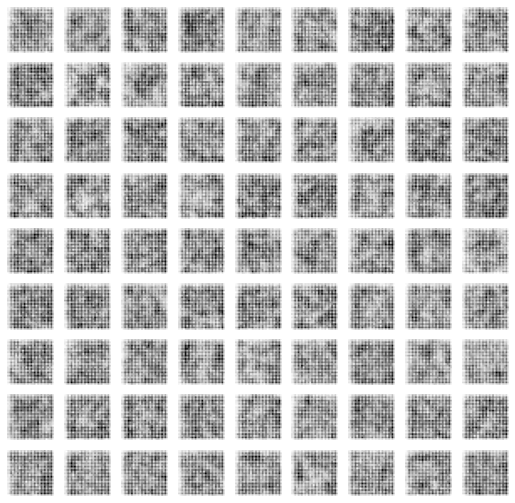

E:1, G_Accuracy:%0.00, D_Accuracy:%99.56, G_Loss:0.6931, D_Loss:0.5032
E:2, G_Accuracy:%0.00, D_Accuracy:%99.74, G_Loss:0.6931, D_Loss:0.5032


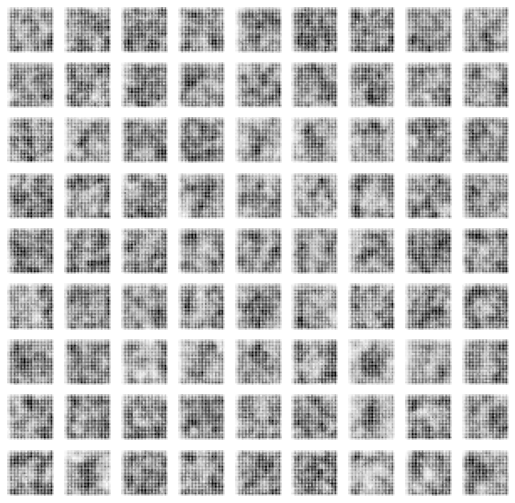

E:3, G_Accuracy:%0.00, D_Accuracy:%99.82, G_Loss:0.6931, D_Loss:0.5032
E:4, G_Accuracy:%0.00, D_Accuracy:%99.86, G_Loss:0.6932, D_Loss:0.5032


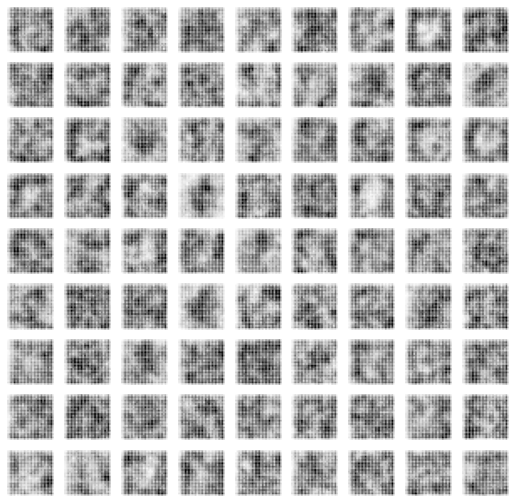

E:5, G_Accuracy:%0.00, D_Accuracy:%99.88, G_Loss:0.6932, D_Loss:0.5032
E:6, G_Accuracy:%0.00, D_Accuracy:%99.90, G_Loss:0.6932, D_Loss:0.5032


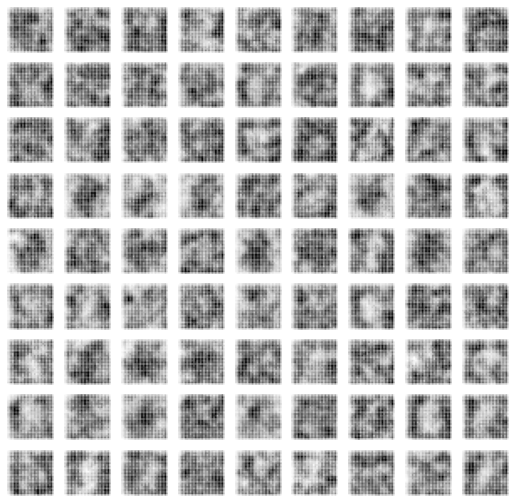

E:7, G_Accuracy:%0.00, D_Accuracy:%99.91, G_Loss:0.6932, D_Loss:0.5032
E:8, G_Accuracy:%0.00, D_Accuracy:%99.92, G_Loss:0.6894, D_Loss:0.5079


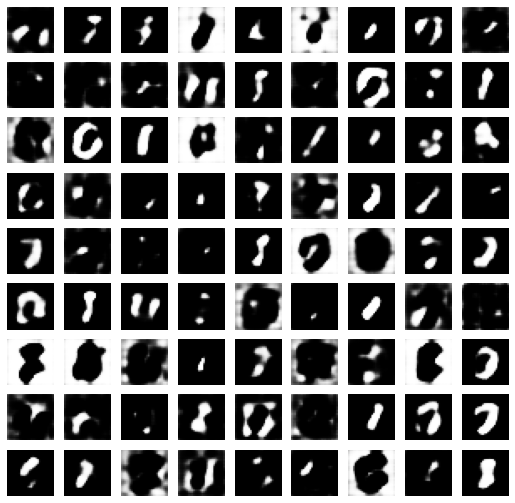

E:9, G_Accuracy:%0.31, D_Accuracy:%99.06, G_Loss:0.6506, D_Loss:0.5941
E:10, G_Accuracy:%0.95, D_Accuracy:%96.38, G_Loss:0.6442, D_Loss:0.6469


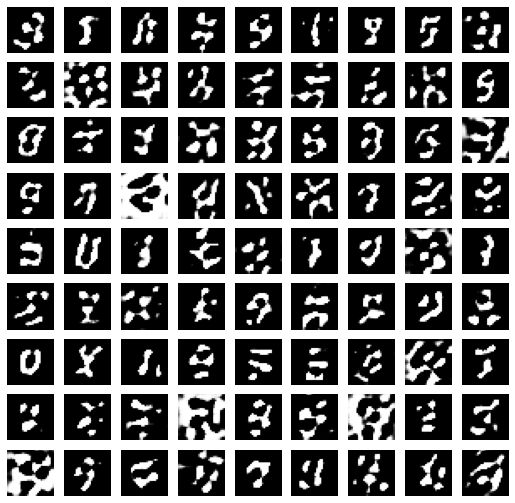

E:11, G_Accuracy:%1.48, D_Accuracy:%93.84, G_Loss:0.6367, D_Loss:0.6158
E:12, G_Accuracy:%1.63, D_Accuracy:%93.27, G_Loss:0.6405, D_Loss:0.5785


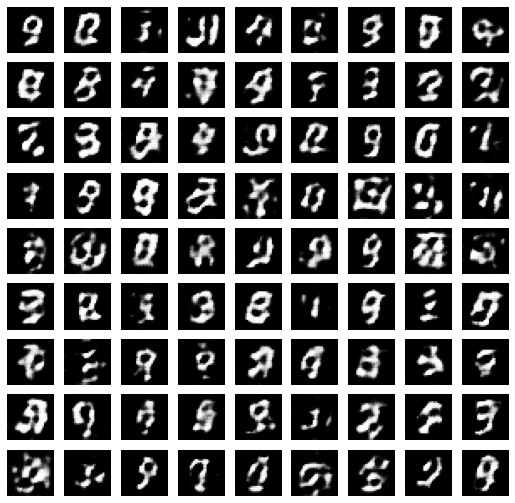

E:13, G_Accuracy:%1.67, D_Accuracy:%92.88, G_Loss:0.6444, D_Loss:0.5726
E:14, G_Accuracy:%1.70, D_Accuracy:%92.68, G_Loss:0.6490, D_Loss:0.5686


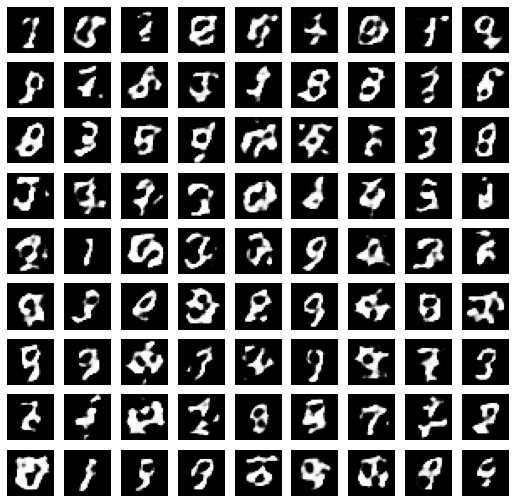

E:15, G_Accuracy:%1.75, D_Accuracy:%92.46, G_Loss:0.6510, D_Loss:0.5699
E:16, G_Accuracy:%1.78, D_Accuracy:%92.22, G_Loss:0.6532, D_Loss:0.5676


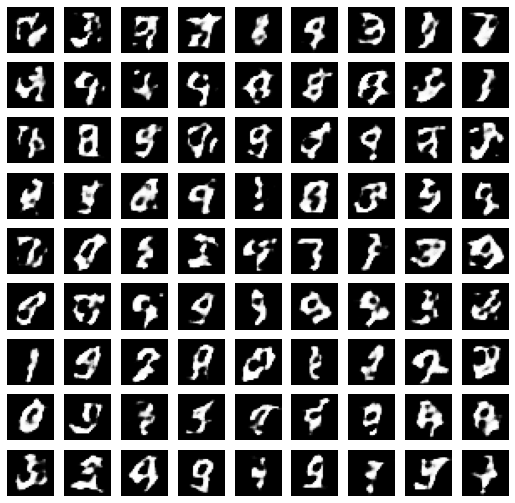

E:17, G_Accuracy:%1.80, D_Accuracy:%92.04, G_Loss:0.6558, D_Loss:0.5645
E:18, G_Accuracy:%1.82, D_Accuracy:%91.90, G_Loss:0.6567, D_Loss:0.5626


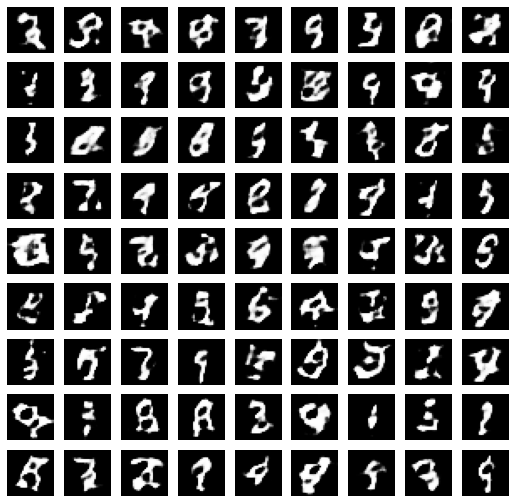

E:19, G_Accuracy:%1.85, D_Accuracy:%91.78, G_Loss:0.6575, D_Loss:0.5614
E:20, G_Accuracy:%1.86, D_Accuracy:%91.69, G_Loss:0.6587, D_Loss:0.5590


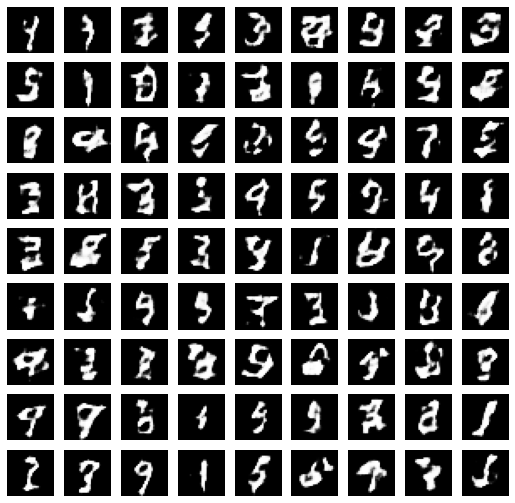

E:21, G_Accuracy:%1.88, D_Accuracy:%91.63, G_Loss:0.6585, D_Loss:0.5584
E:22, G_Accuracy:%1.90, D_Accuracy:%91.56, G_Loss:0.6582, D_Loss:0.5596


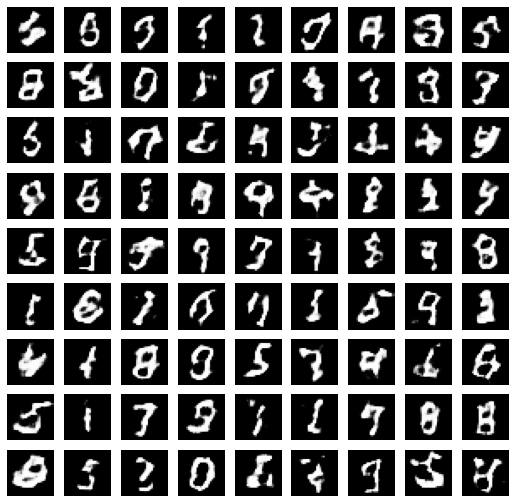

E:23, G_Accuracy:%1.93, D_Accuracy:%91.49, G_Loss:0.6572, D_Loss:0.5615
E:24, G_Accuracy:%1.96, D_Accuracy:%91.40, G_Loss:0.6561, D_Loss:0.5635


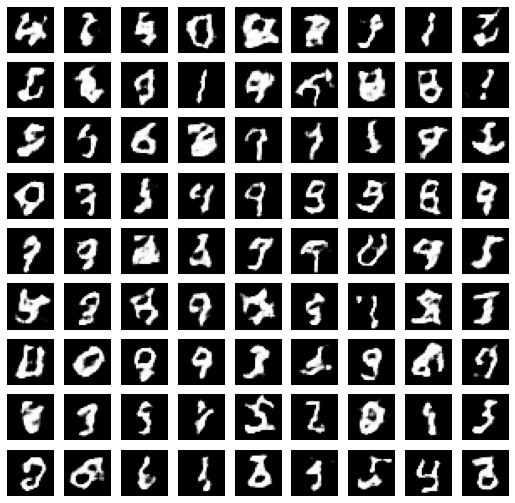

E:25, G_Accuracy:%2.01, D_Accuracy:%91.29, G_Loss:0.6541, D_Loss:0.5672
E:26, G_Accuracy:%2.07, D_Accuracy:%91.17, G_Loss:0.6524, D_Loss:0.5695


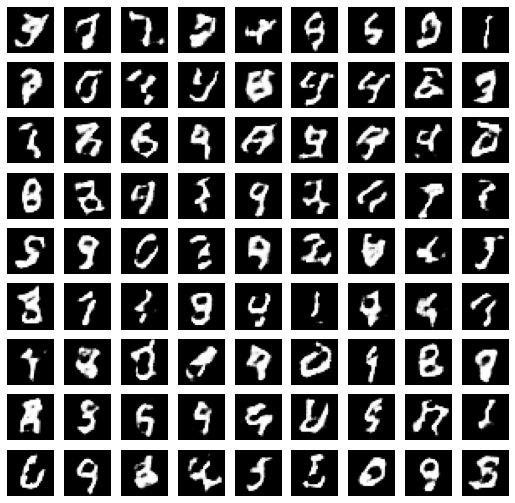

E:27, G_Accuracy:%2.14, D_Accuracy:%91.03, G_Loss:0.6511, D_Loss:0.5718
E:28, G_Accuracy:%2.22, D_Accuracy:%90.89, G_Loss:0.6508, D_Loss:0.5717


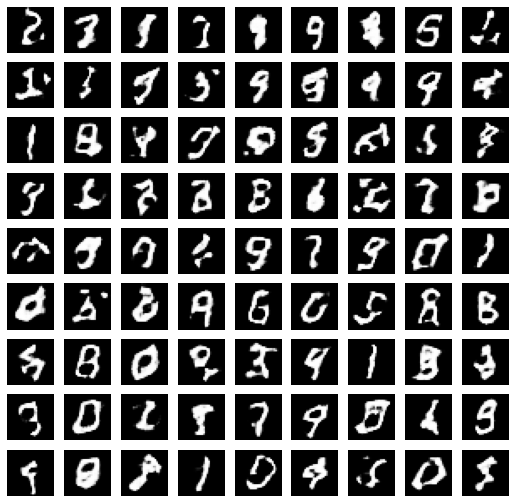

E:29, G_Accuracy:%2.29, D_Accuracy:%90.76, G_Loss:0.6507, D_Loss:0.5710
E:30, G_Accuracy:%2.36, D_Accuracy:%90.66, G_Loss:0.6508, D_Loss:0.5703


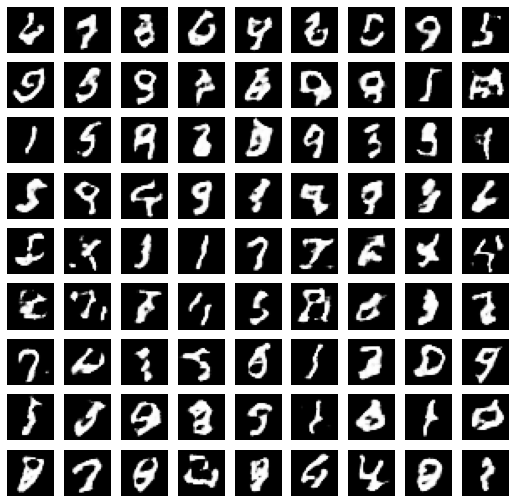

E:31, G_Accuracy:%2.43, D_Accuracy:%90.56, G_Loss:0.6511, D_Loss:0.5693
E:32, G_Accuracy:%2.49, D_Accuracy:%90.48, G_Loss:0.6518, D_Loss:0.5682


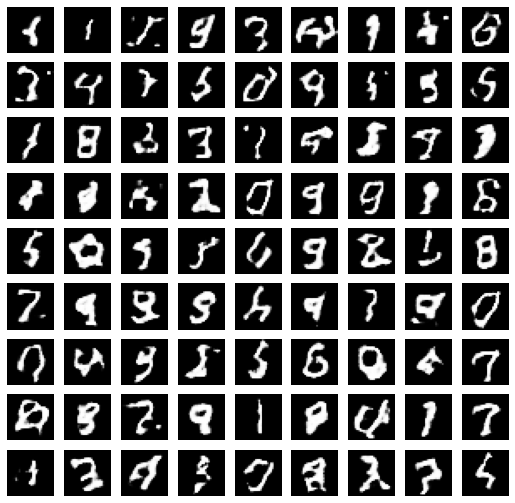

E:33, G_Accuracy:%2.55, D_Accuracy:%90.41, G_Loss:0.6520, D_Loss:0.5675
E:34, G_Accuracy:%2.60, D_Accuracy:%90.35, G_Loss:0.6527, D_Loss:0.5665


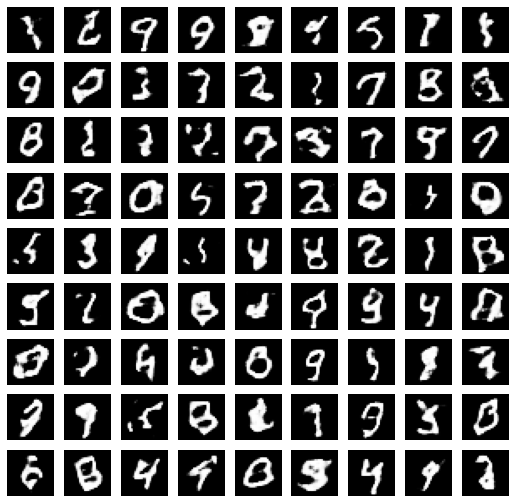

E:35, G_Accuracy:%2.65, D_Accuracy:%90.30, G_Loss:0.6529, D_Loss:0.5657
E:36, G_Accuracy:%2.69, D_Accuracy:%90.25, G_Loss:0.6534, D_Loss:0.5652


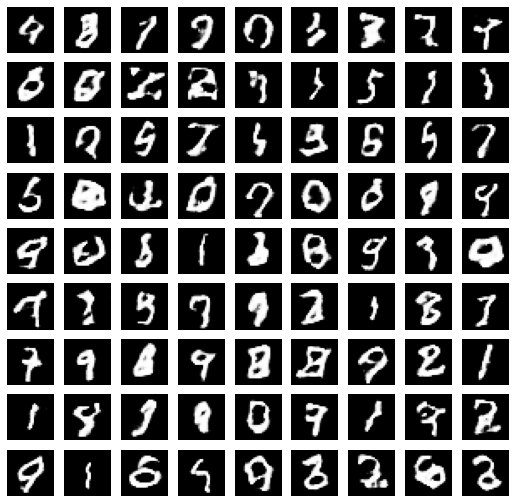

E:37, G_Accuracy:%2.73, D_Accuracy:%90.21, G_Loss:0.6533, D_Loss:0.5647
E:38, G_Accuracy:%2.77, D_Accuracy:%90.17, G_Loss:0.6536, D_Loss:0.5642


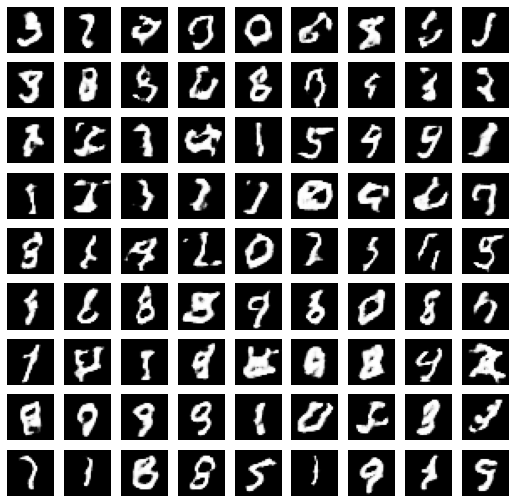

E:39, G_Accuracy:%2.81, D_Accuracy:%90.14, G_Loss:0.6543, D_Loss:0.5627
E:40, G_Accuracy:%2.84, D_Accuracy:%90.13, G_Loss:0.6550, D_Loss:0.5619


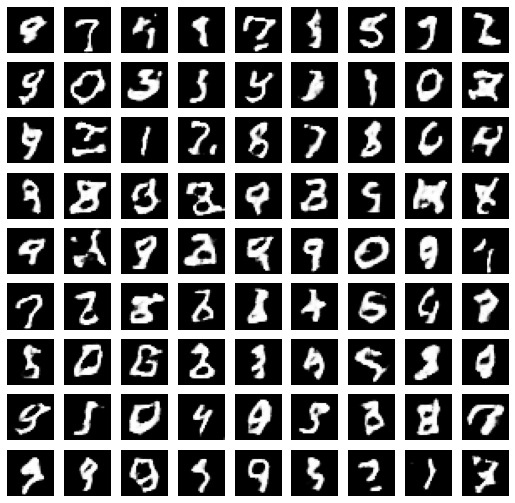

E:41, G_Accuracy:%2.87, D_Accuracy:%90.11, G_Loss:0.6554, D_Loss:0.5609
E:42, G_Accuracy:%2.89, D_Accuracy:%90.10, G_Loss:0.6562, D_Loss:0.5601


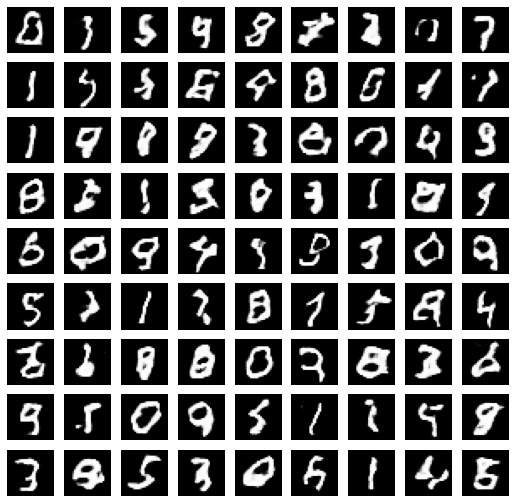

E:43, G_Accuracy:%2.91, D_Accuracy:%90.10, G_Loss:0.6568, D_Loss:0.5592
E:44, G_Accuracy:%2.93, D_Accuracy:%90.10, G_Loss:0.6575, D_Loss:0.5581


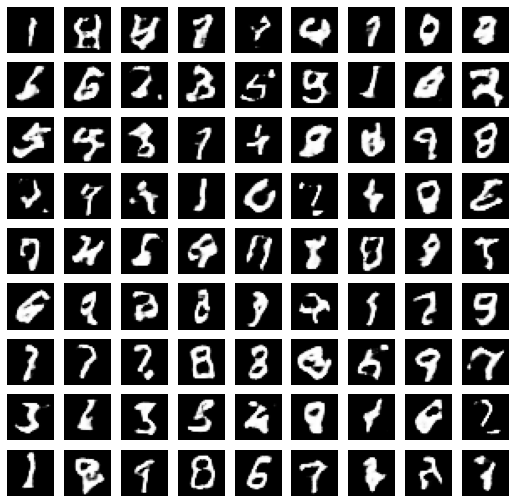

E:45, G_Accuracy:%2.94, D_Accuracy:%90.10, G_Loss:0.6580, D_Loss:0.5570
E:46, G_Accuracy:%2.96, D_Accuracy:%90.11, G_Loss:0.6588, D_Loss:0.5560


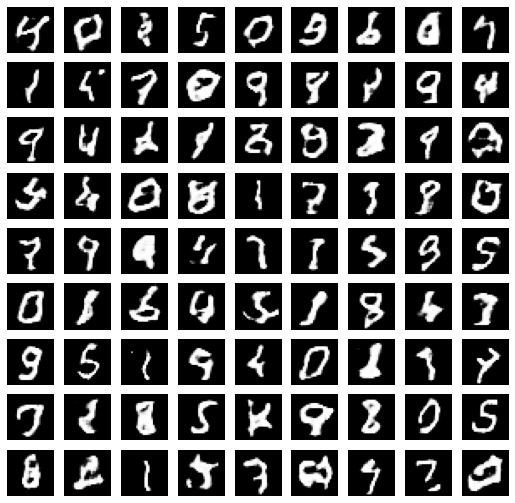

E:47, G_Accuracy:%2.97, D_Accuracy:%90.13, G_Loss:0.6590, D_Loss:0.5551
E:48, G_Accuracy:%2.98, D_Accuracy:%90.15, G_Loss:0.6594, D_Loss:0.5543


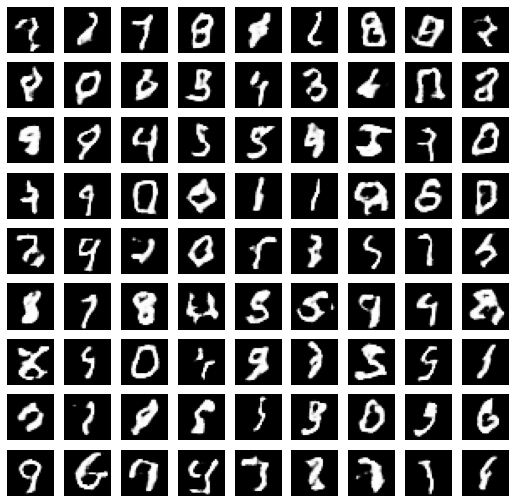

E:49, G_Accuracy:%2.98, D_Accuracy:%90.17, G_Loss:0.6601, D_Loss:0.5535


In [10]:
for epoch in range(50):
  dLossSum = 0
  gLossSum = 0
  dAccSum = 0
  gAccSum = 0
  count = 0

  for batch in dset:
    dLoss = trainDStep(batch)
    dLossSum += dLoss['Discriminator_Loss']
    dAccSum += dLoss['Discriminator_Accuracy']

    
    gLoss = trainGStep(batch)
    gLossSum += gLoss['Generator_Loss']
    gAccSum += gLoss['Generator_Accuracy']

    count += 1

  # log the performance
  print("E:{}, G_Accuracy:%{:0.2f}, D_Accuracy:%{:0.2f}, G_Loss:{:0.4f}, D_Loss:{:0.4f}".format(
      epoch,
      100 * gAccSum/count,
      100 * dAccSum/count,
      gLossSum/count,
      dLossSum/count      
  ))
    
  if epoch % 2 == 0:
    Images(generator)